# Вычисления на GPU

__Автор задач: Блохин Н.В. (NVBlokhin@fa.ru)__

Материалы: 
* Макрушин С.В. Лекция "GPGPU"
* https://numpy.org/doc/stable/reference/generated/numpy.load.html
* https://docs.cupy.dev/en/stable/user_guide/basic.html
* https://carpentries-incubator.github.io/gpu-speedups/01_CuPy_and_Numba_on_the_GPU/index.html
* https://carpentries-incubator.github.io/lesson-gpu-programming/02-cupy/index.html
* https://carpentries-incubator.github.io/gpu-speedups/01_CuPy_and_Numba_on_the_GPU/index.html
* https://www.youtube.com/watch?v=9bBsvpg-Xlk
* https://numba.pydata.org/numba-doc/latest/user/vectorize.html
* https://numba.pydata.org/numba-doc/latest/cuda/ufunc.html
* https://towardsdatascience.com/cuda-by-numba-examples-1-4-e0d06651612f


Для выполнения данной работы рекомендуется использовать среду Google Colab. Перед началом работы смените среду выполнения на GPU. 

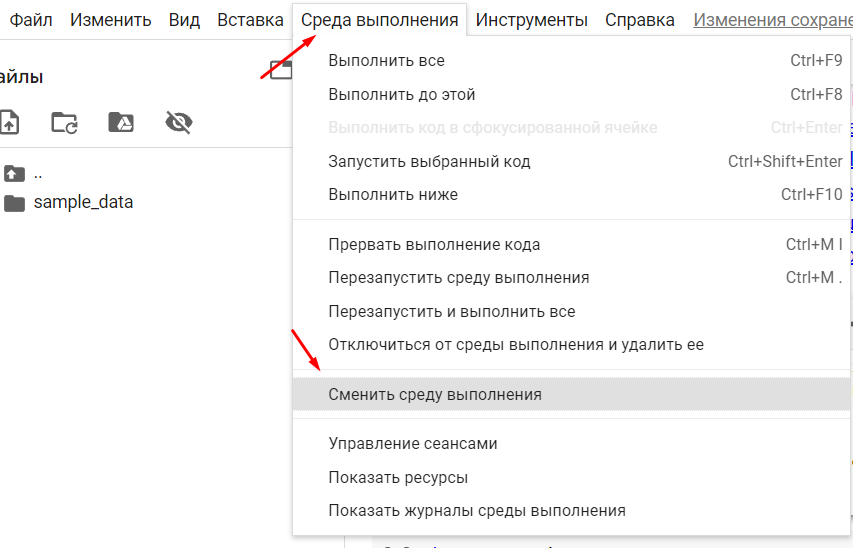

Обратите внимание, что время графического процессора, которое предоставляет Google, ограничено. 

In [ ]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [ ]:
!nvidia-smi

Thu May 25 07:18:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Задачи для совместного разбора

In [ ]:
import numpy as np
import cupy as cp

1. Создайте массив `cupy`, заполненный числами из стандартного нормального распределения. Исследуйте основные характеристики массива (размеры, устройство, тип). Сравните время выполнения нескольких аналогичных операций с `numpy` и `cupy`. 

In [ ]:
A_cpu = np.random.normal(0, 1, size=(10_000, 10_000))

In [ ]:
A_cpu.nbytes # в памяти оперативки

800000000

In [ ]:
A_gpu = cp.random.normal(0, 1, size=(10_000, 10_000)) #  в памяти графического процессора

In [ ]:
A_gpu.device

<CUDA Device 0>

In [ ]:
%%time
(A_cpu ** 2).sum()

CPU times: user 169 ms, sys: 176 ms, total: 345 ms
Wall time: 607 ms


100007268.76033989

In [ ]:
%%time
(A_gpu ** 2).sum() # первые вызовы где-то кешируются, дальше исполняются быстро

CPU times: user 168 ms, sys: 6.75 ms, total: 175 ms
Wall time: 340 ms


array(1.00007352e+08)

In [ ]:
%%time
(A_gpu ** 2).sum()

CPU times: user 328 µs, sys: 75 µs, total: 403 µs
Wall time: 414 µs


array(1.00007352e+08)

In [ ]:
#A_cpu + A_gpu нелья
# cp.linalg.svd(A_cpu)
#np.linalg.svd(A_gpu) иногда работает, но происходит выгрузка данных в оперативку

In [ ]:
A = A_cpu
# A = A_gpu

In [ ]:
xp = cp.get_array_module(A)

In [ ]:
xp.sum(A)

19186.84166020971

2. Напишите функцию `f(x, y)`, которая считает sin(x) + cos(y), если они одинакового знака (или хотя бы одно из них равно нулю), и cos(x) + sin(y) в противном случае. Векторизуйте функцию при помощи numba с различными значениями аргумента `target`. Создайте 2 массива и выполните вычисления. Создайте ядро CUDA и выполните те же вычисления.

In [ ]:
import math
def f(x, y):
  if x * y >= 0:
    return math.sin(x) + math.cos(y)
  return math.cos(x) + math.sin(y)

In [ ]:
A = np.random.randint(-100, 100, size=1000000)
B = np.random.randint(-100, 100, size=1000000)

In [ ]:
A.dtype

dtype('int64')

In [ ]:
import numba

In [ ]:
import numba

f1 = numba.vectorize(["float64(int64, int64)"])(f)
f2 = numba.vectorize(["float64(int64, int64)"], target='parallel')(f)
f3 = numba.vectorize(["float64(int64, int64)"], target='cuda')(f)

In [ ]:
%%timeit
f1(A, B)

57.3 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
f2(A, B)

65.8 ms ± 22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
%%timeit
f3(A, B)

9.96 ms ± 2.01 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


![image.png](attachment:image.png)

In [ ]:
from numba import cuda

In [ ]:
@cuda.jit
def kernel(A, B, C):
  i = cuda.grid(1) # индекс эл-та, который обрабатывается в данном вызове
  if i < len(A):
    x = A[i]
    y = B[i]
    if x * y >= 0:
      r = math.sin(x) + math.cos(y)
    else:
      r = math.cos(x) + math.sin(y)
    C[i] = r

In [ ]:
C = np.zeros_like(A, dtype=np.float64)
threadsperblock = 512

N = len(A)
blockspergrid = (N + threadsperblock - 1) // threadsperblock

kernel[blockspergrid, threadsperblock](A, B, C)

/usr/local/lib/python3.10/dist-packages/numba/cuda/cudadrv/devicearray.py:885: NumbaPerformanceWarning: Host array used in CUDA kernel will incur copy overhead to/from device.
  warn(NumbaPerformanceWarning(msg))


3. Создайте два тензора `A` и `B`, заполненные числами из стандартного нормального распределения. Решите матричное уравнение `AX = B`. Повторите решение с использованием GPU.

In [ ]:
import torch as th

In [ ]:
A = th.normal(0,1, size=(100_000, 1000))

In [ ]:
# A.requires_grad
A.device

device(type='cpu')

In [ ]:
device = th.device("cuda")
A_gpu = A.to(device)
A_gpu.device

device(type='cuda', index=0)

In [ ]:
A_gpu = A.cuda()

In [ ]:
A_gpu.sum()

tensor(-14280.0615, device='cuda:0')

In [ ]:
A = th.normal(0,1, size=(10_000, 10_000))
B = th.normal(0, 1, size=(10_000, 5))
# AX=B

In [ ]:
%%time
X = th.linalg.inv(A) @ B

CPU times: user 36.4 s, sys: 384 ms, total: 36.8 s
Wall time: 37.2 s


In [ ]:
A_gpu = A.cuda()
B_gpu = B.cuda()

In [ ]:
%%time
X_gpu = th.linalg.inv(A) @ B

CPU times: user 36.1 s, sys: 365 ms, total: 36.5 s
Wall time: 36.5 s


## Лабораторная работа 15

__При решении данных задач не подразумевается использования циклов или генераторов Python в ходе работы с пакетами `numpy`, `cupy`, `numba` и `torch`, если в задании не сказано обратного. Решения задач, в которых для обработки массивов используются явные циклы (без согласования с преподавателем), могут быть признаны некорректными и не засчитаны.__

### CyPy

<p class="task" id="1"></p>

1\. В файле "blobs.npz" находится четыре массива: 
* X - 1 млн 128-мерных векторов;
* centers - центроиды кластеров;
* y1 - вариант кластеризации точек;
* y2 - альтернативный вариант кластеризации точек.

Считайте эти данные в виде массива `cupy.ndarray`. Используя пакет `cupy`, вычислите и выведите на экран:
* размерость каждого из заданных массивов;
* объем памяти, занимаемой каждым из массивов (в мегабайтах);
* количество точек в каждом из кластеров в соответствии с разбиением `y1`;
* количество точек в каждом из кластеров в соответствии с разбиением `y2`.

In [1]:
! gdown 1Ecv9ufAZbbXjcVSFXrLM2w9b1-KY1Izq

Downloading...
From: https://drive.google.com/uc?id=1Ecv9ufAZbbXjcVSFXrLM2w9b1-KY1Izq
To: /content/blobs.npz
100% 1.04G/1.04G [00:18<00:00, 56.6MB/s]


In [2]:
import cupy as cp

In [3]:
data = cp.load('blobs.npz')

In [ ]:
data['X'].shape, data['centers'].shape, data['y1'].shape, data['y2'].shape

((1000000, 128), (3, 128), (1000000,), (1000000,))

In [ ]:
(data['X'].nbytes / 1048576, 
data['y1'].nbytes / 1048576, 
data['y2'].nbytes / 1048576)

(976.5625, 7.62939453125, 7.62939453125)

<p class="task" id="2"></p>

2\. Используя пакет `numpy`, выясните, какое из разбиений (`y1` или `y2`) лучше разделяет данные на кластеры. Для этого вычислите среднее значение евклидова расстояния от каждой точки до центроида присвоенного ей кластера. Выведите данные значения для обоих разбиений на экран и сделайте вывод. Замерьте время выполнения решения при помощи магической команды `timeit`.

In [4]:
import numpy as np

In [6]:
X, centers, y1, y2 = data['X'], data['centers'], data['y1'], data['y2']

In [7]:
X_ = cp.asnumpy(X)
centers_ = cp.asnumpy(centers)
y1_ = cp.asnumpy(y1)
y2_ = cp.asnumpy(y2)

In [ ]:
def func_np():
  L2_1 = np.r_[
      (((X_[y1_ == 0] - centers_[0])**2).sum(axis=1)**0.5),
      (((X_[y1_ == 1] - centers_[1])**2).sum(axis=1)**0.5),
      (((X_[y1_ == 2] - centers_[2])**2).sum(axis=1)**0.5)
  ].mean()
  L2_2 = np.r_[
      (((X_[y2_ == 0] - centers_[0])**2).sum(axis=1)**0.5),
      (((X_[y2_ == 1] - centers_[1])**2).sum(axis=1)**0.5),
      (((X_[y2_ == 2] - centers_[2])**2).sum(axis=1)**0.5)
  ].mean()
  return L2_1, L2_2

In [ ]:
%%timeit
func_np()

1.86 s ± 86.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
func_np()

(69.62724577390182, 11.292487638331728)

**Второе разбиение лучше**

<p class="task" id="3"></p>

3\. Решите задачу 2, воспользовавшись пакетом `cupy`. Замерьте время выполнения решения при помощи магической команды `timeit`. Сравните время выполнения двух решений. Подтвердите (программно), что результаты решений совпадают.

In [ ]:
def func_cp():
  L2_1 = cp.r_[
      (((X[y1 == 0] - centers[0])**2).sum(axis=1)**0.5),
      (((X[y1 == 1] - centers[1])**2).sum(axis=1)**0.5),
      (((X[y1 == 2] - centers[2])**2).sum(axis=1)**0.5)
  ].mean()
  L2_2 = cp.r_[
      (((X[y2 == 0] - centers[0])**2).sum(axis=1)**0.5),
      (((X[y2 == 1] - centers[1])**2).sum(axis=1)**0.5),
      (((X[y2 == 2] - centers[2])**2).sum(axis=1)**0.5)
  ].mean()
  return L2_1, L2_2

In [ ]:
%%timeit
func_cp()

351 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
func_cp()

(array(69.62724577), array(11.29248764))

<p class="task" id="4"></p>

4\. Напишите функцию `test_y`, которая считает среднее значение евклидова расстояния от каждой точки до центроида присвоенного ей кластера. Реализуйте функцию таким образом, чтобы она могла корректно работать и с массивами `numpy`, и с массивами `cupy`. Если в функции передается часть аргументов в виде массивов `numpy`, а часть - в виде массивов `cupy`, должно быть возбуждено исключение `ValueError`. Подтвердите правильность решения различными примерами.

```python
def test_y(X, y, centers):
  pass
```

In [39]:
def test_y(X, y, centers):
  print(type(X), type(y), type(centers))
  try:
    if type(X) == type(y) or type(X) == type(centers):
      xp = cp.get_array_module(X)
      L2 = xp.r_[
        (((X[y == 0] - centers[0])**2).sum(axis=1)**0.5),
        (((X[y == 1] - centers[1])**2).sum(axis=1)**0.5),
        (((X[y == 2] - centers[2])**2).sum(axis=1)**0.5)
      ].mean()
      return L2
    else:
      raise ValueError
  except:
      print('Возбуждено исключение ValueError')

In [40]:
test_y(X, y1, centers)

<class 'cupy.ndarray'> <class 'cupy.ndarray'> <class 'cupy.ndarray'>


array(69.62724577)

In [41]:
test_y(X_, y1_, centers_)

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


69.62724577390182

In [42]:
test_y(X, y1_, centers_)

<class 'cupy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
Возбуждено исключение ValueError


### Numba

<p class="task" id="5"></p>

5\. Даны массива `numbers` и `powers`. Реализуйте функцию `power_sum`, которая находит сумму всех цифр числа `number`, возведенных в степень `power`. Для каждой пары `(numbers[i], power[i])` вычислите `power_sum` , найдите максимум этой величины и выведите ее на экран. Решите задачу при помощи декоратора `numba.vectorize` с различными значениями аргумента `target`: `cpu`, `parallel` и `cuda`. Замерьте время выполнения каждого из решений.

```python
def power_sum(number: int, power: int) -> int:
  pass
```

In [ ]:
def power_sum(number: int, power: int) -> int:
  return number ** power

In [ ]:
import numpy as np
np.random.seed(42)

N = 10_000_000

numbers = np.random.randint(0, 1000, size=N)
powers = np.random.randint(1, 5, size=N)

In [ ]:
%%time
max_el = max(power_sum(numbers, powers))

CPU times: user 591 ms, sys: 13 ms, total: 604 ms
Wall time: 606 ms


In [ ]:
max_el

996005996001

In [ ]:
numbers.dtype

dtype('int64')

In [ ]:
import numba

In [ ]:
@numba.vectorize("int64(int64, int64)", target='cpu')
def power_sum_cpu(number: int, power: int) -> int:
  return number ** power

In [ ]:
%%time
max_el = max(power_sum_cpu(numbers, powers))
max_el

CPU times: user 578 ms, sys: 18.6 ms, total: 597 ms
Wall time: 597 ms


996005996001

In [ ]:
@numba.vectorize("int64(int64, int64)", target='parallel')
def power_sum_par(number: int, power: int) -> int:
  return number ** power

In [ ]:
%%time
max_el = max(power_sum_par(numbers, powers))
max_el

CPU times: user 811 ms, sys: 29.2 ms, total: 841 ms
Wall time: 680 ms


996005996001

In [ ]:
@numba.vectorize("int64(int64, int64)", target='cuda')
def power_sum_cuda(number: int, power: int) -> int:
  return number ** power

In [ ]:
%%time
max_el = max(power_sum_cuda(numbers, powers))
max_el

CPU times: user 711 ms, sys: 222 ms, total: 933 ms
Wall time: 1.11 s


996005996001

<p class="task" id="6"></p>

6\. Преобразуйте `power_sum` в device function при помощи декоратора `numba.cuda.jit`. Напишите ядро `power_sum_kernel` и решите с его помощью задачу 5.

In [ ]:
from numba import cuda

In [ ]:
@cuda.jit
def power_sum_kernel(number, power, res):
  i = cuda.grid(1)
  if i < len(number):
    x = number[i]
    y = power[i]
    res[i] = number ** power

In [ ]:
# %%time
# res = np.zeros_like(numbers, dtype=np.int64)
# threadsperblock = 512

# N = len(numbers)
# blockspergrid = (N + threadsperblock - 1) // threadsperblock

# power_sum_kernel[blockspergrid, threadsperblock](numbers, powers, res)

### PyTorch

In [ ]:
import torch as th

<p class="task" id="7"></p>

7\. Создайте тензор размера 256х64. Заполните его числами из равномерного распределения $U(-a, a)$, где $a=3\sqrt{\frac{6}{256+64}}$. Выведите на экран основные характеристики тензора:
* кол-во строк;
* кол-во столбцов;
* кол-во элементов;
* тип данных;
* устройство.

In [ ]:
a = 3 * (6 / (256 + 64)) ** .5
tens = th.FloatTensor(256, 64).uniform_(-a, a)

In [ ]:
tens.shape[0]

256

In [ ]:
tens.shape[1]

64

In [ ]:
tens.numel()

16384

In [ ]:
tens.dtype

torch.float32

In [ ]:
tens.device

device(type='cpu')

<p class="task" id="8"></p>

8\. Создайте тензор `A`, заполненный целыми числами из отрезка [-1, 1] (при создании зафиксируйте зерно ГПСЧ, равное 42). Получите матрицу B по правилу $B = \frac{A + A^T}{2}$. Проверьте, является ли матрица симметричной. Используя `torch`, получите SVD-разложение матрицы `B`. Проверьте, насколько точно разложение приближает исходную матрицу (для оценки качества используйте норму Фробениуса). Измерьте время выполнения решения.

In [ ]:
th.manual_seed(42)
A = th.randint(-1, 2, size=(1000, 1000))

In [ ]:
B = (A + A.T)/2

In [ ]:
(B.T == B).all()

tensor(True)

In [ ]:
%%time
U, S, V = th.linalg.svd(B)
norm_B = th.norm(B, p='fro')
norm_S = th.norm(S, p='fro')
norm_B, norm_S # равны, следовательно, разложение приближает исходную матрицу

CPU times: user 368 ms, sys: 6.76 ms, total: 374 ms
Wall time: 408 ms


(tensor(577.4002), tensor(577.4002))

<p class="task" id="9"></p>

9\. Повторите решение задачи 8, перенеся вычисления на GPU. Сравните результаты и время выполнения двух решений.

In [ ]:
from numba import cuda

In [ ]:
A_gpu = A.cuda()
A_gpu.device

device(type='cuda', index=0)

In [ ]:
B_gpu = (A_gpu + A_gpu.T)/2

In [ ]:
%%timeit
U, S, V = th.linalg.svd(B_gpu)
norm_B = th.norm(B_gpu, p='fro')
norm_S = th.norm(S, p='fro')
norm_B, norm_S 

169 ms ± 784 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
norm_B, norm_S # равны, следовательно, разложение приближает исходную матрицу

(tensor(577.4002, device='cuda:0'), tensor(577.4810, device='cuda:0'))